# Ras Differential Expression Analysis

Perform a t-test across all genes to determine differentially expressed genes between Ras wildtype and Ras mutant genes. Compare with what the model learns and output the data for visualization with R/ggplot2.

In [1]:
import os
import sys
import pandas as pd
import scipy
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

sys.path.insert(0, os.path.join('..', 'scripts', 'util'))
from tcga_util import integrate_copy_number

/home/gway/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

Loading RNAseq (X matrix), copy number and mutation (Y matrix), and coefficients data (W matrix from machine learning model)

In [3]:
# Load RNAseq matrix
expr_file = os.path.join('..', 'data', 'pancan_rnaseq_freeze.tsv')
rnaseq_full_df = pd.read_table(expr_file, index_col=0)

In [4]:
# Load Mutation matrix
mut_file = os.path.join('..', 'data', 'pancan_mutation_freeze.tsv')
mutation_df = pd.read_table(mut_file, index_col=0)

In [5]:
# Load sample freeze data and cancer genes
sample_freeze_file = os.path.join('..', 'data', 'sample_freeze.tsv')
sample_freeze = pd.read_table(sample_freeze_file, index_col=0)

cancer_gene_file = os.path.join('..', 'data', 'vogelstein_cancergenes.tsv')
cancer_genes = pd.read_table(cancer_gene_file)

In [6]:
# Load copy number data to determine final status matrix
copy_loss_file = os.path.join('..', 'data', 'copy_number_loss_status.tsv')
copy_gain_file = os.path.join('..', 'data', 'copy_number_gain_status.tsv')

copy_loss_df = pd.read_table(copy_loss_file, index_col=0)
copy_gain_df = pd.read_table(copy_gain_file, index_col=0)

In [7]:
# Load Coefficients File
coef_file = os.path.join('..', 'classifiers', 'RAS', 'classifier_coefficients.tsv')
coef_df = pd.read_table(coef_file, index_col=0)

## Process and Prep Data for Differential Expression Analysis

In [8]:
# Process y matrix
genes = ['KRAS', 'HRAS', 'NRAS']
y = mutation_df[genes]

y_df = integrate_copy_number(y=y, cancer_genes_df=cancer_genes,
                             genes=genes, loss_df=copy_loss_df,
                             gain_df=copy_gain_df)

y_df = y_df.assign(total_status=y.max(axis=1))
y_df = y_df.reset_index().merge(sample_freeze,
                          how='left').set_index('SAMPLE_BARCODE')

In [9]:
y_df['total_status'].value_counts()

0    8008
1    1066
Name: total_status, dtype: int64

In [10]:
# Subset X matrix to coefficients
x_df = rnaseq_full_df.loc[:, coef_df['feature']]
x_df = x_df.dropna(axis=1)

x_df_update = StandardScaler().fit_transform(x_df)
x_df_update = pd.DataFrame(x_df_update, columns=x_df.columns, index=x_df.index)
x_df = x_df_update

In [11]:
# Get two arrays to compare
ras_wt_samples = y_df[y_df['total_status'] == 0].index
ras_mut_samples = y_df[y_df['total_status'] == 1].index

x_wt_df = x_df.loc[ras_wt_samples, :]
x_mut_df = x_df.loc[ras_mut_samples, :]

## Perform the analysis and output results

In [12]:
ttest_results = scipy.stats.ttest_ind(x_mut_df, x_wt_df)
t_stat = ttest_results.statistic
p_val = ttest_results.pvalue

In [13]:
ttest_df = pd.DataFrame(t_stat, columns=['stat'])
ttest_df = ttest_df.assign(pval = p_val)
ttest_df = ttest_df.assign(gene = x_wt_df.columns)

In [14]:
plot_df = pd.merge(ttest_df, coef_df, left_on='gene', right_on='feature')
plot_df.head(2)

,stat,pval,gene,feature,weight,abs
0,6.812033,1.023496e-11,PBX3,PBX3,0.139761,0.139761
1,21.001785,1.164957e-95,SPRY2,SPRY2,0.123713,0.123713


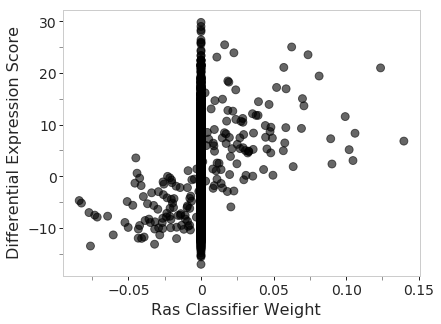

<ggplot: (8756998175089)>

In [15]:
p = (gg.ggplot(plot_df, gg.aes(x='weight', y='stat')) +
     gg.geom_point(size=4, alpha=0.6) +
     gg.theme_seaborn(style='whitegrid') +
     gg.xlab('Ras Classifier Weight') +
     gg.ylab('Differential Expression Score') +
     gg.ggtitle('') +
     gg.theme(
        plot_title=gg.element_text(size=22),
        axis_title_x=gg.element_text(size=16),
        axis_title_y=gg.element_text(size=16),
        axis_text_x=gg.element_text(size=14),
        axis_text_y=gg.element_text(size=14),
        axis_ticks_length=4,
        legend_position=(1.0, 0.5),
        legend_background=gg.element_blank(),
        legend_key=gg.element_rect(fill='white'),
        legend_text=gg.element_text(size=9),
        legend_title=gg.element_text(size=12),
        panel_border=gg.element_blank(),
        panel_grid_major=gg.element_blank(),
        panel_grid_minor=gg.element_blank()))
p

In [16]:
# Output data for ggplot
diff_exp_file = os.path.join('..', 'classifiers', 'RAS', 'differential_expression.tsv')
plot_df.to_csv(diff_exp_file, sep='\t', index=False)